In [1]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import Quandl as q
import tabulate as tb

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
%matplotlib inline

# Caso 1.1.
## Estimación de una función de demanda de dinero con datos de la economía española.

En el fichero DEMDIN.GDT se ofrece información de la economía española en el periodo 1964-1985 de las siguientes variables:

- M1: Efectivo en manos del público + depósitos a la vista

- ipc: índice de precios al consumo base 1970

- rc: tipo de interés a corto plazo (tipo de los depósitos a menos de un año)

- rl: tipo de interés a largo plazo (rendimiento interno de las obligaciones privadas)

- y: PIB en unidades monetarias constantes de 1970.


>Alternativamente, los datos de M1, producción a precios
constantes y tipo de interés a corto y largo plazo, todos ellos para Europa, se
pueden obtener de la base de datos del Banco de España que se ofrece a través
del propio Gretl en la opción Archivos-Bases de datos-Sobre servidor. El dato
del IPC con base 2005 se puede obtener de la base de datos del BCE en internet.
Se pueden usar todos los datos mensuales y cuando se cargan desde Gretl se
puede decir que convierta los datos trimestrales en mensuales interpolando. Los
datos del IPC habrá que guardarlos en formato Excel y después añadirlos a los
que tengamos en Gretl, teniendo cuidado de que los decimales estén en Excel con
coma y que coincidan los periodos inicial y final.

# Se plantea estimar la siguiente función de demanda de dinero:

## $$log (M1) = β_0 + β_1 log (y) + β_2 log (r) + β_3 log (ipc) + u$$

En el modelo se intenta explicar la demanda de dinero en función de la renta real, utilizándose el PIB, para estimar el efecto del motivo transacción. La segunda variable explicativa, el tipo de interés, recoge el comportamiento de la demanda de dinero especulativo, representando el coste de oportunidad de mantener dinero como forma de ahorro. La última variable, el índice de precios al consumo, se introduce como variable explicativa para valorar el efecto de la inflación sobre la demanda nominal de dinero.

- a)  Estimar el modelo de oferta monetaria, utilizando el tipo de interés a corto plazo para los grupos tipo A y el tipo a largo para los grupos tipo B. Comentar los resultados desde el punto de vista económico y econométrico.

- b)  Contrastar la restricción $β_3 = 1$, comentando sus implicaciones económicas. Hacer los cálculos paso a paso sin usar las opciones directas de Gretl.

- c)  Estimar el modelo asumiendo que la restricción es cierta.

- d)  Suponer que queremos estimar el modelo usando la variable M1 en términos reales, imponiendo para ello la restricción del apartado b), y a la vez seguir manteniendo el ipc como variable explicativa. Pensar cómo transformar el modelo para conseguir el doble objetivo anterior y calcular de forma razonada (con la ayuda de la estimación del apartado a) el valor del coeficiente que acompaña a la variable ipc.

- e)  Estimar al modelo del apartado d) comprobando si se cumple el resultado teórico.

Interpretar económicamente todos los modelos estimados y calcular en cada modelo los contrastes de especificación RESET, normalidad y autocorrelación LM de orden 1 y 2.

# DATOS:

Las variables usadas han sido obtenidas en la base de datos [Quandl](www.quandl.com) y Gretl.  

- __M1:__ Efectivo en manos del público + depósitos a la vista, para la UEM [link](https://www.quandl.com/data/FRED/MYAGM1EZM196N-M1-for-Euro-Area)

- __ipc:__ índice de precios armonizado para todos los ítems base 2005 para la UE28 [link](https://www.quandl.com/data/AMECO/EU28_1_0_0_0_ZCPIH-Harmonised-consumer-price-index-All-items-2005-100-European-Union-28-countries)

- __rc:__ tipo de interés a corto plazo (tipo de los depósitos a menos de un año). Gretl: Base de Datos: Servidor: BE: UEM Tipo de interes interbancario. 3 meses, porcentaje.

- __y:__ PIB en unidades monetarias constantes de 1970. [link](https://www.quandl.com/data/WWDI/EMU_NY_GDP_MKTP_KD-GDP-constant-2000-US-Euro-area) [y2](https://www.quandl.com/data/ECB/ESA_A_V3_N_0000_B1QG00_1000_TTTT_L_U_A-EU-28-Gross-domestic-product-at-market-price-Chain-linked-volumes-reference-year-2005-ECU-euro)

In [4]:
# datos
r = pd.read_excel('fmi_interes_spain.xlsx', skip_rows=0, header=1, index_col=0)
r.columns = ['r']

In [5]:
p = pd.read_excel('fmi_ipc_spain.xlsx', skip_rows=0, header=1, index_col=0)
p.columns = ['p']

In [6]:
m1 = pd.read_excel('fmi_m1_spain.xlsx', skip_rows=0, header=1, index_col=0)
m1.columns = ['m1']

In [7]:
y = pd.read_excel('fmi_pib_spain.xlsx',skip_rows=0, header=1, index_col=0)
y.columns = ['y']

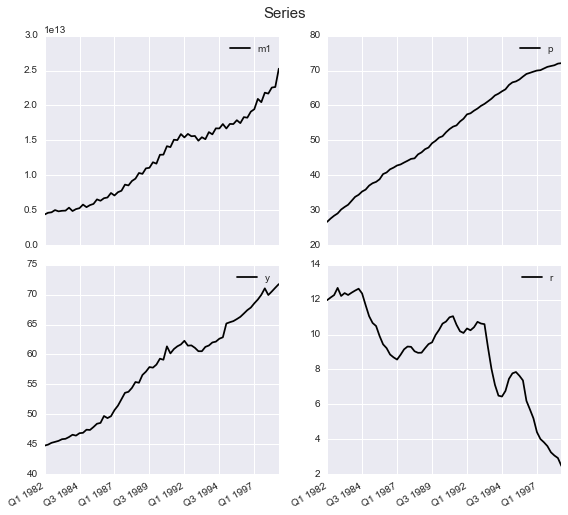

In [54]:
data = pd.concat([m1 , p, y, r], axis=1, join='inner')
data.dropna(inplace=True)
data.plot(subplots=True, layout=(2,2), figsize=(8,7))
plt.tight_layout()
plt.suptitle('Series', y=1.015, fontsize=15)
plt.savefig('imgs/series.png', bbox_inches='tight')

In [9]:
data.head()

,m1,p,y,r
Q1 1982,4363000000000,26.637351,44.744559,11.970000
Q2 1982,4611700000000,27.584677,44.912734,12.123333
Q3 1982,4684000000000,28.391079,45.216270,12.263333
Q4 1982,5003400000000,29.040898,45.375656,12.673333
Q1 1983,4821800000000,30.160465,45.541487,12.210000


In [10]:
data.tail()

,m1,p,y,r
Q4 1997,21834900000000,71.072951,71.054916,3.600000
Q1 1998,21705700000000,71.310435,69.937077,3.246667
Q2 1998,22567600000000,71.534871,70.530850,3.060000
Q3 1998,22653200000000,72.004619,71.158433,2.916667
Q4 1998,25270600000000,72.135105,71.763124,2.463333


In [11]:
endog = data.m1
exog = data.ix[:,1:]
exog = sm.add_constant(exog)
modelo = sm.OLS(endog, exog)
reg = modelo.fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                     m1   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1001.
Date:                Fri, 09 Oct 2015   Prob (F-statistic):           1.07e-53
Time:                        09:00:59   Log-Likelihood:                -1962.9
No. Observations:                  68   AIC:                             3934.
Df Residuals:                      64   BIC:                             3943.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -2.376e+13    2.3e+12    -10.318      0.0

In [71]:
data_log = np.log(data)
endog = data_log.m1
exog = data_log.ix[:,1:]
exog = sm.add_constant(exog)
modelo = sm.OLS(endog, exog)
reg = modelo.fit()

In [72]:
print(reg.summary())

f = open('mco.txt', 'r+')
print(reg.summary(), file=f)
f.close()

                            OLS Regression Results                            
Dep. Variable:                     m1   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2309.
Date:                Fri, 09 Oct 2015   Prob (F-statistic):           3.80e-65
Time:                        09:30:58   Log-Likelihood:                 107.11
No. Observations:                  68   AIC:                            -206.2
Df Residuals:                      64   BIC:                            -197.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         16.3003      0.531     30.706      0.0

In [73]:
X = exog
norm_x = X.values
for i, name in enumerate(X):
    if name == "const":
        continue
    norm_x[:,i] = X[name]/np.linalg.norm(X[name])
norm_xtx = np.dot(norm_x.T,norm_x)


In [74]:
print(tb.tabulate(norm_xtx, headers=('cons', 'y', 'p', 'rcp'), tablefmt='rst'))

========  ========  ========  ========
    cons         y         p       rcp
========  ========  ========  ========
68        8.22397   8.24079   8.11066
 8.22397  1         0.999253  0.97136
 8.24079  0.999253  1         0.978026
 8.11066  0.97136   0.978026  1
========  ========  ========  ========


# APARTADO A

El modelo sin logaritmos da problemas de significatividad de los parámetros. Al hacer el modelo propuesto en el enunciado, vemos que mejora considerablemente. 

Analizando paso por paso,

## El modelo planteado:

$$ log(M1) = \beta_1 log(p) + \beta_2 log(y) + \beta_3 log(rc) + u$$

Planteamos un modelo MCO para la regresión anterior y obtenemos los siguientes resultados:

### PRINCIPALES RESULTADOS

$\beta   = valor  \ (t-ratio)$

$\beta_0\ =\ 16.3003\ (0.531)$

$\beta_1\ =\ 0.39820\ (0.108)$

$\beta_2\ =\ 2.96300\ (0.222)$

$\beta_3\ =\ 0.09100\ (0.024)$

Con todos los parámetros significativos y una vez comprobado que se cumplen los supuestos del modelo lineal general, podemos interpretar el modelo en términos económicos.

Dado que estamos ante un modelo __doblemente logarítmico__ tenemos que interpretar los parámetros de posición como __elasticidades__, esto es, el incremento de un punto porcentual que afecta a la oferta monetaria.

### EL TÉRMINO INDEPENDIENTE ($\beta_0$)

Vemos por tanto que la interpretación del término __independiente ('const')__ es que si no se producen cambios en la renta, precios y el tipo de interés la oferta monetaria tiene un valor que tenemos que hallar, este valor es:

$log(M1) = \beta_0$

$e^{log(M1)} = e^{\beta_0}$

$M1 = e^{\beta_0} $

$M1 = e^{16.3003} = 11 998 593.59$

### EL EFECTO DEL PRECIO SOBRE LA OFERTA MONETARIA ($\beta_1$)

El $\beta_1 = 0.3982$ nos dice que si aumentan los precios en un 1%, la oferta monetaria lo hace en un 0.3982%, es decir, que si hay inflación la oferta monetaria aumenta menos relativamente menos de la mitad. Esto tiene sentido con lo que nos dice la Teoría Económica, ya que:

$ \frac{M}{P} = m(r,y) $

$ log(\frac{M}{P} = log[m(r,y)] $

$ log(M) - log(P)  = log[m(r,y)] $

$ log(M) = log[m(r,y)] + log(P) $

__DERIVANDO:__

$ \frac{d(M)}{M} = \frac{m_r·d(r) + m_y · d(y)}{m(r,y)} + \frac{d(P)}{P}$ con dr, dy = 0

$ \frac{d(M)}{M} = \frac{d(P)}{P} $

Por lo tanto aumentan en la misma dirección. Importante notar que en un esquema de modelo Keynesiano o Clásico, P es una variable endógena mientras que M es exógenas, para esta última, es importante notar que las autoridades monetarias deciden M y no r como es en la realidad.

### EL EFECTO DE LA RENTA EN LA OFERTA MONETARIA ($\beta_2$)

El $\beta_2 = 2.9630$ nos dice que incrementos en de un 1% en la renta, tiene un efecto de un 2.9630% en la oferta monetaria, casi 3 veces mas intenso relativamente. Esto tiene sentido ya que por teoría sabemos que el multiplicador de la demanda de dinero tiene efecto positivo.

### EL EFECTO DEL TIPO DE INTERÉS EN LA OFERTA MONETARIA ($\beta_3$)

Por último $ \beta_3  = 0.0910 $ nos dice que aumentos del 1% del tipo de interés(%), tiene un efecto del 0.0910% sobre la oferta de dinero. Teniendo en cuenta que para el modelo planteado la oferta monetaria es exógena, y el tipo de interés (r) es endógena, esto nos indica cómo debería cambiar la oferta monetaria para conseguir un cambio en el tipo de interés, así pues:

$ \frac{d(M)}{M} = \beta_3 d(r) $

$ \frac{1}{\beta_3} · \frac{d(M)}{M} = d(r) $

$ \frac{1}{0.0910} · \frac{d(M)}{M} = d(r) $

$ 10.989011 \frac{d(M)}{M} = d(r) $

El signo del $\beta_3$ es el mismo que el $m_r$ que según la teoría nos dice que $m_r < 0$ por lo tanto tenemos una contradicción con la realidad. Al ser de un 0.0910 muy pequeño lo que nos dice que la elasticidad de la oferta monetaria al tipo de interés es inelástica. Esto implica que la economía podría encontrarse en una situación en la que la política monetaria deja de ser tan efectiva, en el modelo keynesiano a esto se le denomina trampa de la liquidez.

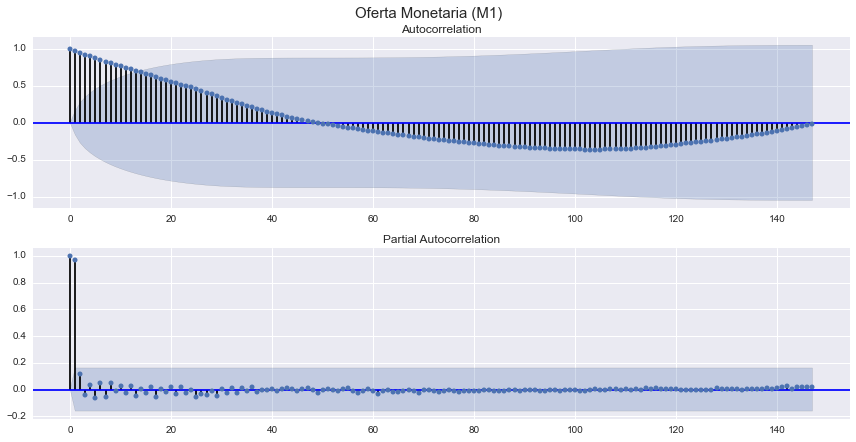

In [45]:
fsize = (12,6)

plt.figure(figsize=fsize)
ax1 = plt.subplot(2,1,1)
plot_acf(m1, ax=ax1)
ax2 = plt.subplot(2,1,2)
plot_pacf(m1, ax=ax2)
plt.suptitle('Oferta Monetaria (M1)', fontsize=15, y=1.015)
plt.tight_layout()
plt.savefig('imgs/m1_acor.png', bbox_inches='tight')

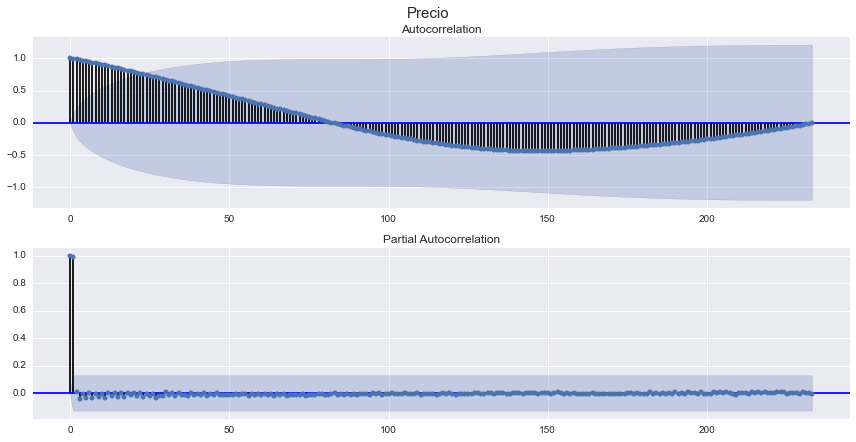

In [46]:
plt.figure(figsize=fsize)
ax1 = plt.subplot(2,1,1)
plot_acf(p, ax=ax1)
ax2 = plt.subplot(2,1,2)
plot_pacf(p, ax=ax2)
plt.suptitle('Precio', fontsize=15, y=1.015)
plt.tight_layout()
plt.savefig('imgs/m1_acor.png', bbox_inches='tight')

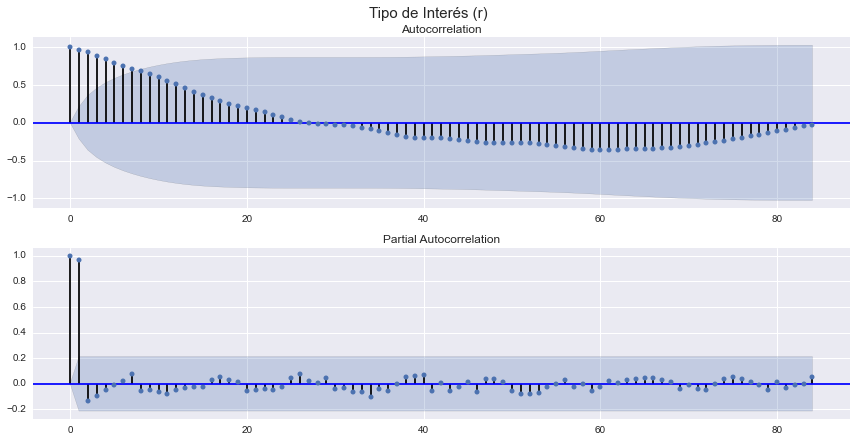

In [47]:
plt.figure(figsize=fsize)
ax1 = plt.subplot(2,1,1)

plot_acf(r, ax=ax1)
ax2 = plt.subplot(2,1,2)

plot_pacf(r, ax=ax2)
plt.suptitle('Tipo de Interés (r)', fontsize=15, y=1.015)
plt.tight_layout()
plt.savefig('imgs/m1_acor.png', bbox_inches='tight')

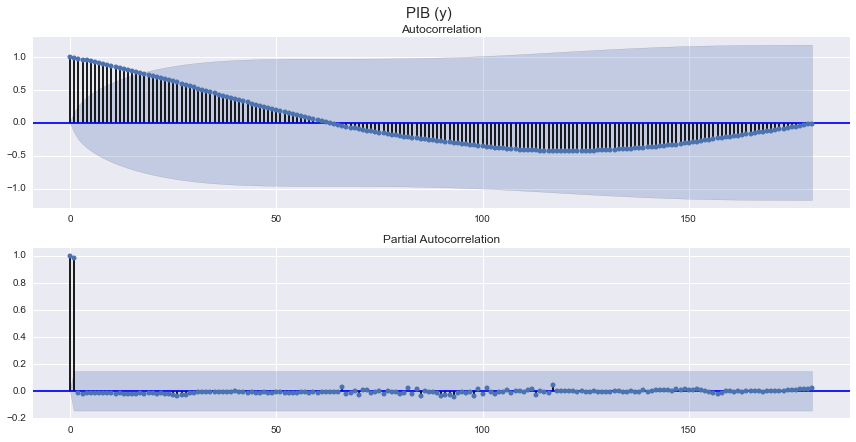

In [48]:
plt.figure(figsize=fsize)
ax1 = plt.subplot(2,1,1)
plot_acf(y, ax=ax1)
ax2 = plt.subplot(2,1,2)
plot_pacf(y, ax=ax2)
plt.suptitle('PIB (y)', fontsize=15, y=1.015)
plt.tight_layout()
plt.savefig('imgs/m1_acor.png', bbox_inches='tight')

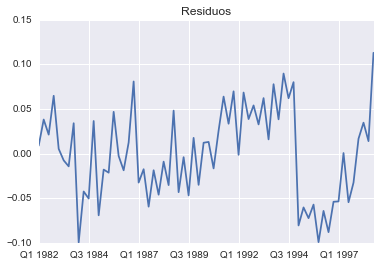

In [49]:
# residuos:
reg.resid.plot(title='Residuos')
plt.savefig('imgs/m1_acor.png', bbox_inches='tight')